In [172]:
import pandas as pd
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

In [173]:
M_NAMES = ["precision", "recall", "fscore"]
M_LABELS = ["Precision", "Recall", "F1-Score"]

In [174]:
def colormap(metric, title, runs):
    cmap = "cool_r"
    fig, ax = plt.subplots()
    _metric = runs[f"metrics.{metric}"]
    g = sns.scatterplot(x="params.size", y="params.overlap", data=runs, c=_metric, cmap=cmap, size=_metric,
                        legend=False)
    g.set_xlabel("Subset Size")
    g.set_ylabel("Overlap")

    # color bar
    norm = plt.Normalize(_metric.min(), _metric.max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.06, ax.get_position().height / 2])
    ax.figure.colorbar(sm, cax=cax)

    plt.suptitle(title)

In [175]:
def compare_metrics(data, param, param_name, title, m_names, m_labels, **x_tick_params):
    fig, ax = plt.subplots(1, len(m_labels), sharey=True)
    for i, (m_name, m_label) in enumerate(zip(m_names, m_labels)):
        sns.boxplot(data=data, x=f"params.{param}", y=f"metrics.{m_name}", ax=ax[i], color=f"C{i}")
        ax[i].set_ylabel(m_label)
    for x in ax.flatten():
        x.xaxis.set_tick_params(labelbottom=True, **x_tick_params)
        x.yaxis.set_tick_params(labelleft=True)
    [x.set_xlabel(param_name) for x in ax]
    fig.suptitle(title)

In [176]:
# set figure size
fig_size = [9, 6]
fig_size_small = [5, 3]
plt.rcParams['figure.figsize'] = fig_size

# Search Runs

In [177]:
ids_random_varying_sizes_and_overlaps = ["651112999057083515"] # cartesian product from many sizes and overlaps, using 10 seeds per experiment
ids = ["510907071686288999", "337062275817683573", "331509985598984853", "278314973829801495"] # using 26 seeds per experiment. Contains RANDOM (o=0.2, varying sizes), PLZ, AGE, and GENDER
# ids_random_varying_sizes = ["510907071686288999"] # overlap = 0.2 and many sizes, using 26 seeds per value
# ids_age_plz_gender = ["337062275817683573", "331509985598984853", "278314973829801495"]

runs_random_varying_sizes_and_overlaps = mlflow.search_runs(experiment_ids=ids_random_varying_sizes_and_overlaps)
runs = mlflow.search_runs(experiment_ids=ids)

# make numeric wherever possible
runs_random_varying_sizes_and_overlaps = runs_random_varying_sizes_and_overlaps.apply(pd.to_numeric, errors="ignore")
runs = runs.apply(pd.to_numeric, errors="ignore")

# filter by threshold
t = 0.75
runs_random_varying_sizes_and_overlaps = runs_random_varying_sizes_and_overlaps[runs_random_varying_sizes_and_overlaps["tags.t"] == t]
runs = runs[runs["tags.t"] == t]

# filter by subset selection
runs_random_varying_sizes = runs[runs["params.subset_selection"] == "RANDOM"]
runs_age = runs[runs["params.subset_selection"] == "AGE"]
runs_plz2 = runs[(runs["params.subset_selection"] == "PLZ")
                 & (runs["params.digits"] == 2)]
runs_plz3 = runs[(runs["params.subset_selection"] == "PLZ")
                 & (runs["params.digits"] == 3)]
runs_gender = runs[(runs["params.subset_selection"] == "ATTRIBUTE_VALUE")
                   & (runs["params.column"] == "GENDER")]

## Random subsets

In [178]:
runs_random_mean = runs_random_varying_sizes_and_overlaps.groupby(by=["params.overlap", "params.size"]).mean()
len(runs_random_mean)

/tmp/ipykernel_20647/182597946.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  runs_random_mean = runs_random_varying_sizes_and_overlaps.groupby(by=["params.overlap", "params.size"]).mean()


129

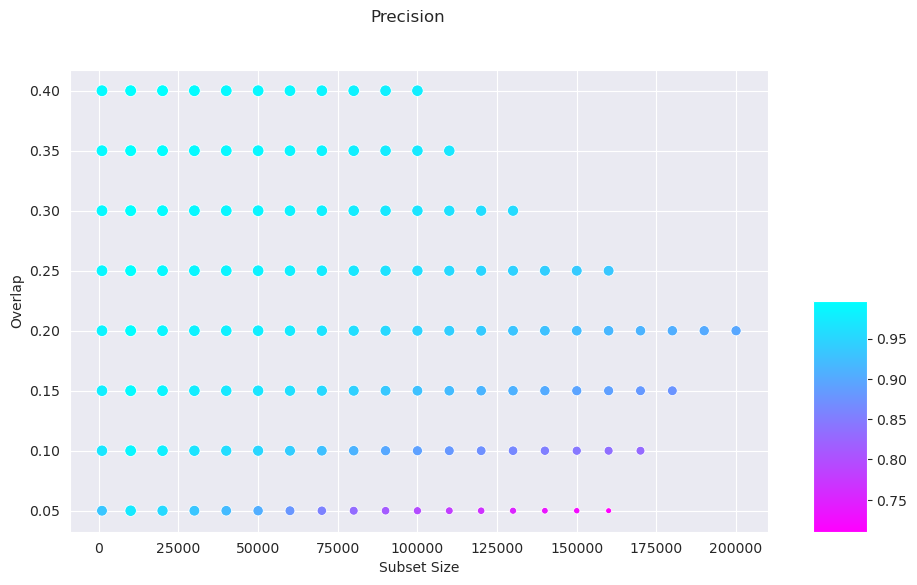

In [179]:
colormap("precision", "Precision", runs_random_mean)
plt.savefig("plots/colormaps/p.png")

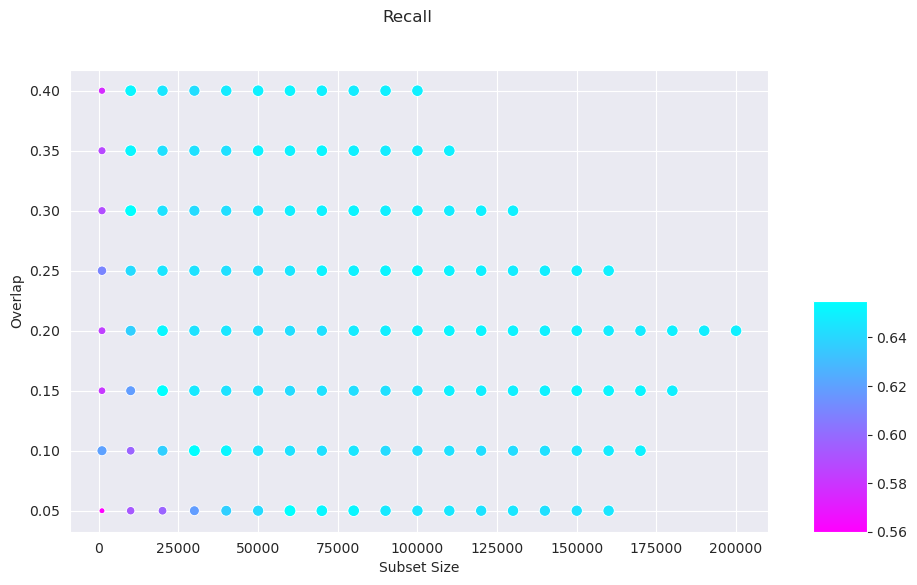

In [180]:
colormap("recall", "Recall", runs_random_mean)
plt.savefig("plots/colormaps/r.png")

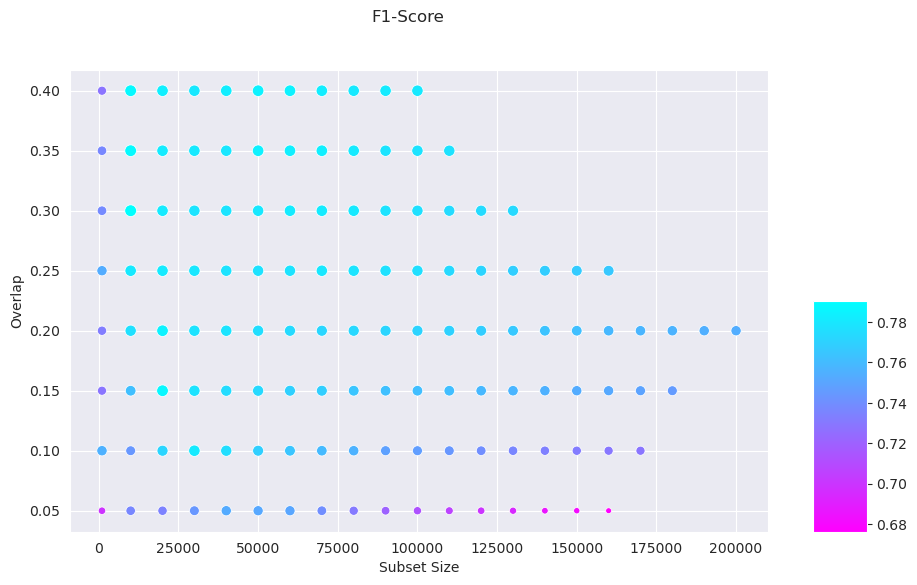

In [181]:
colormap("fscore", "F1-Score", runs_random_mean)
plt.savefig("plots/colormaps/f.png")

### Influence of subset size

In [182]:
def box_plot(data, param: (str, str), metric: (str, str), ylim=None, color="C0"):
    m_name, m_label = metric
    p_name, p_label = param
    sns.boxplot(data=data, x=f"params.{p_name}", y=f"metrics.{m_name}",  color=color)
    plt.xlabel(p_label)
    plt.ylabel(m_label)
    plt.xticks(rotation=45)
    if ylim is not None:
        plt.ylim(ylim)

In [183]:
def influence_of_a(runs, a_name, a_label, b_name, b_val, ylim=None):
    runs_fixed_b = runs[runs[f"params.{b_name}"] == b_val]
    for i, m in enumerate(zip(M_NAMES, M_LABELS)):
        box_plot(data=runs_fixed_b, param=(a_name, a_label), metric=m, ylim=ylim, color=f"C{i}")
        plt.savefig(f"plots/random/{a_name}_{m[0][0]}.png")
        plt.show()

In [184]:
overlap = 0.2
runs_random_varying_sizes_small = runs_random_varying_sizes[runs_random_varying_sizes["params.size"] <= 10000]
runs_random_varying_sizes_large = runs_random_varying_sizes[runs_random_varying_sizes["params.size"] >= 10000]

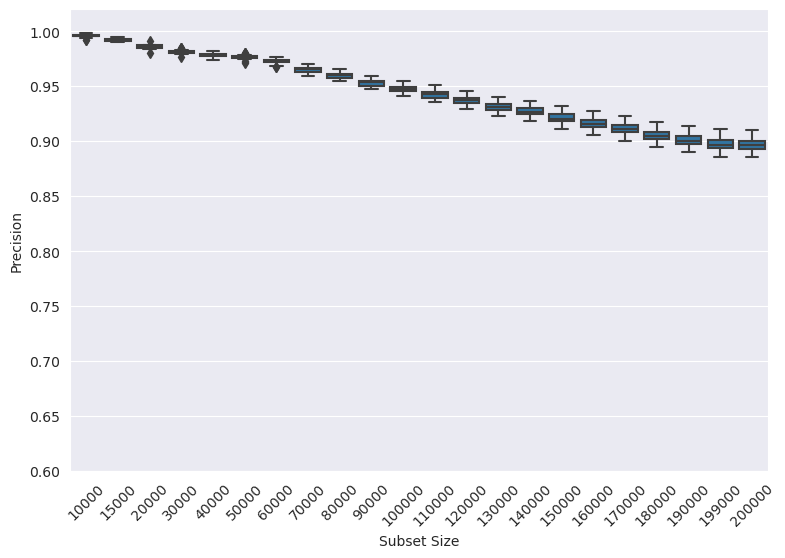

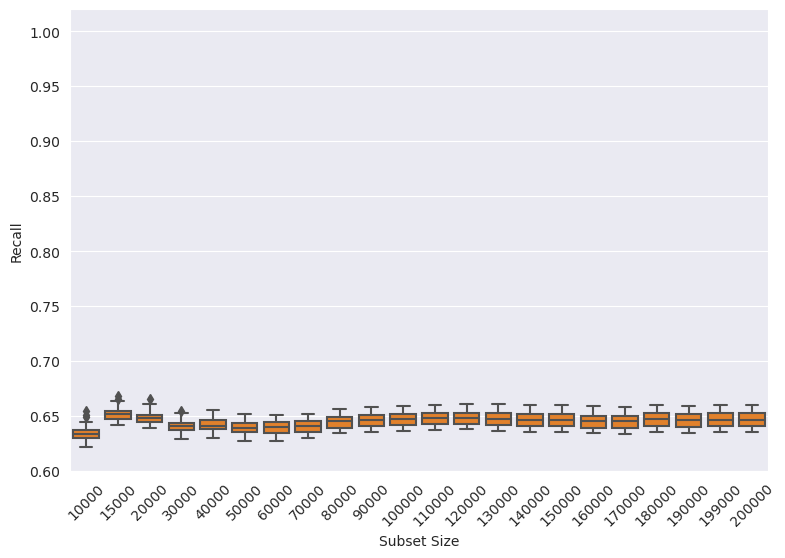

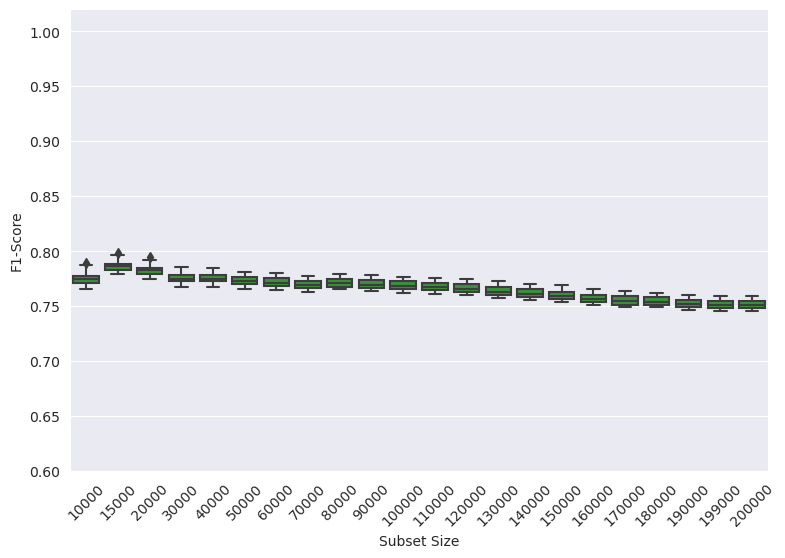

In [185]:
influence_of_a(runs_random_varying_sizes_large, a_name="size", a_label="Subset Size", b_name="overlap", b_val=overlap, ylim=[.6, 1.02])

### Influence of Overlap

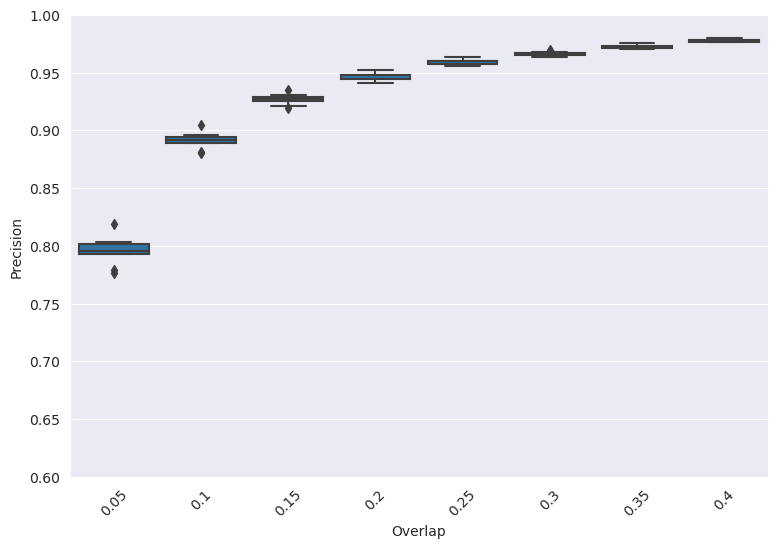

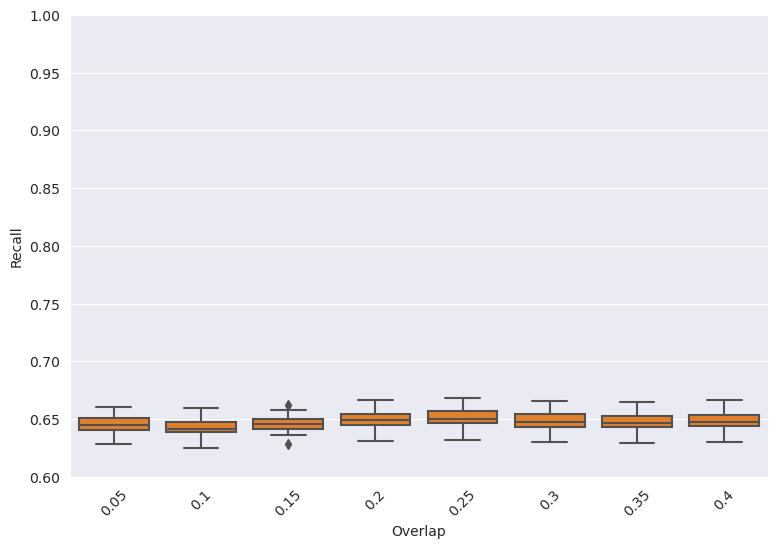

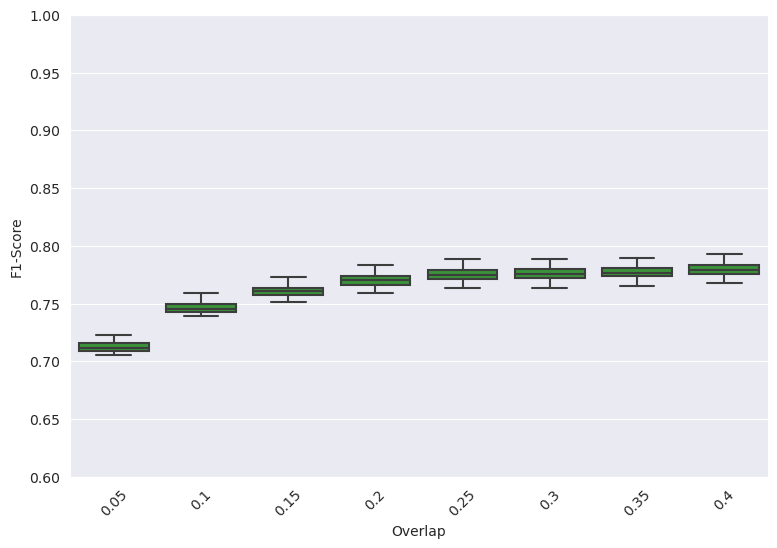

In [186]:
size = 100_000
influence_of_a(runs_random_varying_sizes_and_overlaps, a_name="overlap", a_label="Overlap", b_name="size", b_val=size, ylim=[.6, 1])

# Age, PLZ, Gender Subsets

## Age

In [187]:
map_age_range = {
    "[20, 39]": "0-39",
    "[40, 59]": "40-59",
    "[60, 1000]": ">60"
}
runs_age["params.range"] = runs_age["params.range"].apply(lambda v: map_age_range.get(v, v))
runs_age = runs_age.sort_values(by="params.range")

/tmp/ipykernel_20647/2350726381.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_age["params.range"] = runs_age["params.range"].apply(lambda v: map_age_range.get(v, v))


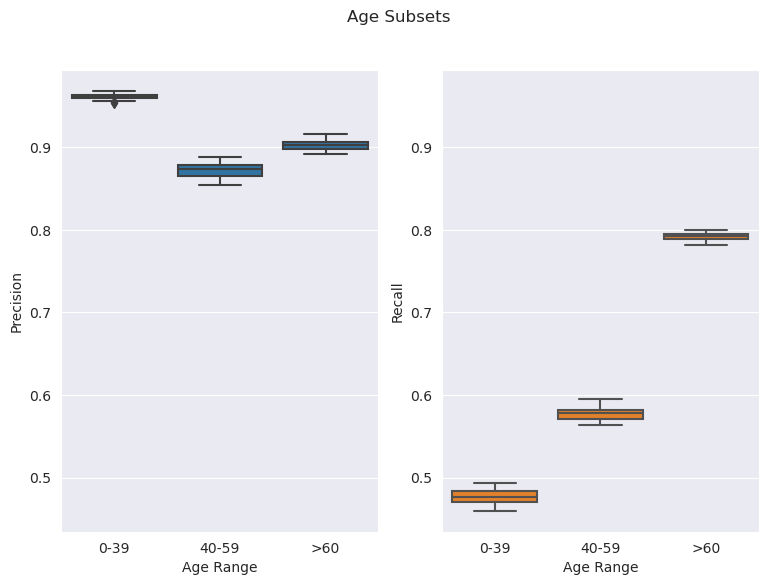

In [188]:
m_names = M_NAMES[:2]
m_labels = M_LABELS[:2]

compare_metrics(runs_age, "range", "Age Range", "Age Subsets", m_names, m_labels)
plt.savefig("plots/attr/age.png")

0-39:
* precision high -> not many FP
* recall low -> many FN
* -> need lower t or lower k ?

## PLZ

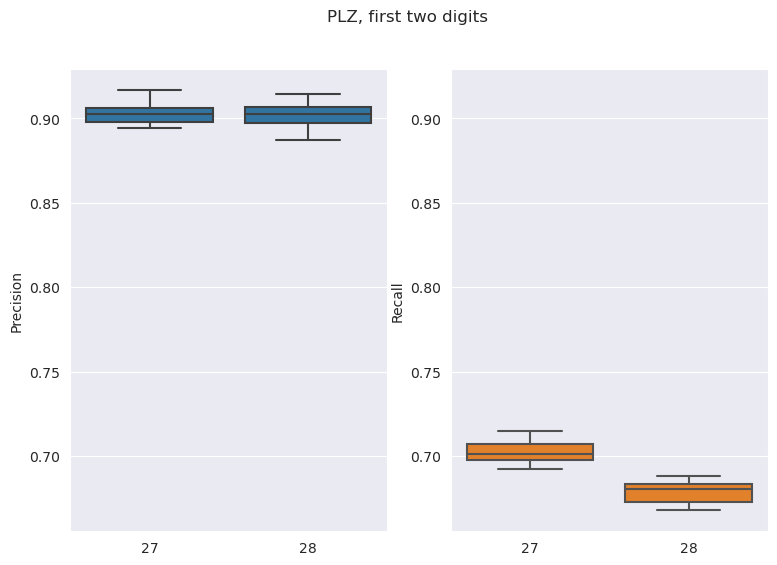

In [189]:
compare_metrics(runs_plz2, "equals", "", "PLZ, first two digits", m_names, m_labels)
plt.savefig("plots/attr/plz2.png")

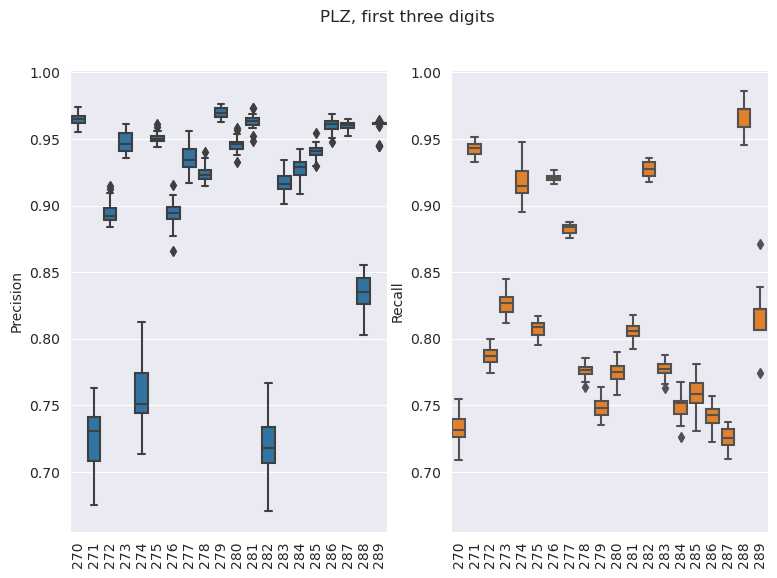

In [190]:
compare_metrics(runs_plz3.sort_values(by=["params.equals"]), "equals", "", "PLZ, first three digits", m_names, m_labels, rotation=90)
plt.savefig("plots/attr/plz3.png")

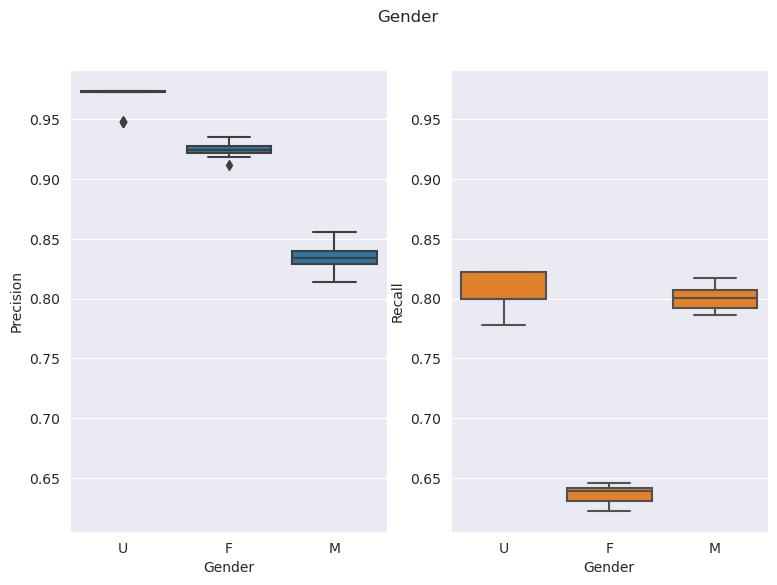

In [191]:
compare_metrics(runs_gender, "equals", "Gender", "Gender", m_names, m_labels)
plt.savefig("plots/attr/gender.png")